In [31]:
from google.colab import drive
from google.colab import files

import torch
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader, random_split, Dataset
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

import os
import zipfile
from PIL import Image
import json
import copy

from datetime import datetime

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f" Using device: {device}")

 Using device: cuda


In [3]:
class DriverBehaviorDataset(Dataset):
    def __init__(self, images, labels, transform=None):
        self.images = images  # NumPy array: (N, H, W, C)
        self.labels = labels  # NumPy array: (N,)
        self.transform = transform

        self.classes = [
            "other_activities",
            "safe_driving",
            "talking_phone",
            "texting_phone",
            "turning"
        ]

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img = Image.fromarray(self.images[idx].astype('uint8'))  # convert back to PIL
        label = self.labels[idx]

        if self.transform:
            img = self.transform(img)

        return img, label

In [4]:

drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
!pip install kaggle

In [6]:
files.upload()

# Crear carpeta y mover el archivo
os.makedirs("/root/.kaggle", exist_ok=True)
!mv kaggle.json /root/.kaggle/kaggle.json
!chmod 600 /root/.kaggle/kaggle.json


Saving kaggle.json to kaggle.json


In [7]:
!kaggle datasets download arafatsahinafridi/multi-class-driver-behavior-image-dataset

Dataset URL: https://www.kaggle.com/datasets/arafatsahinafridi/multi-class-driver-behavior-image-dataset
License(s): unknown
100% 2.38G/2.38G [00:25<00:00, 24.2MB/s]
100% 2.38G/2.38G [00:25<00:00, 98.6MB/s]


In [8]:
img_size = 224

def extract_images():
    zip_path = "/content/multi-class-driver-behavior-image-dataset.zip"

    X = []
    y = []

    classDict = {
        "other_activities": 0,
        "safe_driving": 1,
        "talking_phone": 2,
        "texting_phone": 3,
        "turning": 4
    }

    with zipfile.ZipFile(zip_path, 'r') as zip_file:
        for file in zip_file.namelist():
            # Skip folders
            if file.endswith('/'):
                continue

            # Expected structure: Multi-Class Driver Behavior/<class_name>/<image_file>
            parts = file.split('/')
            if len(parts) >= 3 and parts[1] in classDict:
                class_name = parts[1]
                try:
                    with zip_file.open(file) as src:
                        img = Image.open(src).convert('RGB')
                        img = img.resize((img_size, img_size))
                        X.append(np.array(img))
                        y.append(classDict[class_name])
                except Exception:
                    continue

    return np.array(X), np.array(y)

# Load data
X, y = extract_images()
print("Dataset loaded:", X.shape, y.shape)


Dataset loaded: (7276, 224, 224, 3) (7276,)


In [9]:
np.unique(y, return_counts=True)

(array([0, 1, 2, 3, 4]), array([1184, 1679, 1513, 1561, 1339]))

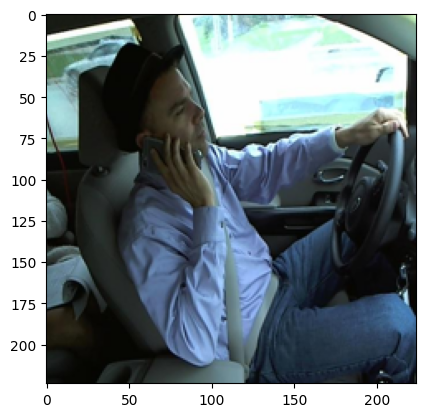

Label: 2


In [10]:
#Demo Image
img_index = 4000
plt.imshow(X[img_index])
plt.show()
print("Label:", y[img_index])

# Preparación de Modelos

In [11]:
# Parametros del modelo
batch_size = 16
learning_rate = 1e-4
# num_epochs = 10
num_workers = 2

In [12]:
train_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),       # Augmentation
    transforms.RandomRotation(10),           # Augmentation
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),  # Optional
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])
test_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],   #RGB mean values of Resnet dataset
                         [0.229, 0.224, 0.225])
])


In [13]:
indices = np.arange(len(X))
train_idx, test_idx = train_test_split(indices, test_size=0.2, stratify=y, random_state=42)

train_dataset = DriverBehaviorDataset(X[train_idx], y[train_idx], transform=train_transform)
test_dataset = DriverBehaviorDataset(X[test_idx], y[test_idx], transform=test_transform)

In [14]:
num_classes = np.unique(y).shape[0]
print("Number of classes:", num_classes)

Number of classes: 5


In [15]:
total_size = len(test_dataset)
train_size = int(0.5 * total_size)
test_size = total_size - train_size

val_data, test_data = random_split(
    test_dataset, [train_size, test_size]
)

In [16]:
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers)
val_loader = DataLoader(val_data, batch_size=batch_size, shuffle=False, num_workers=num_workers)
test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False, num_workers=num_workers)


## Funciones del Modelo


In [ ]:
def create_vgg19_pretrained(num_classes, device):
    """Create VGG19 model with pretrained weights"""
    print("Loading VGG19 pretrained model...")
    model = models.vgg19(pretrained=True)
    model.classifier[6] = nn.Linear(4096, num_classes)
    model = model.to(device)
    return model

def create_vgg19_from_scratch(num_classes, device):
    """Create VGG19 model from scratch (no pretrained weights)"""
    print("Creating VGG19 model from scratch...")
    model = models.vgg19(pretrained=False)
    model.classifier[6] = nn.Linear(4096, num_classes)
    model = model.to(device)
    return model

def train_epoch(model, train_loader, criterion, optimizer, device):
    """Train model for one epoch"""
    model.train()
    running_loss = 0.0
    correct = total = 0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        correct += (predicted == labels).sum().item()
        total += labels.size(0)

    avg_loss = running_loss / len(train_loader)
    accuracy = correct / total
    return avg_loss, accuracy

def validate_epoch(model, val_loader, criterion, device):
    """Validate model for one epoch"""
    model.eval()
    running_loss = 0.0
    correct = total = 0

    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)

            running_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)

    avg_loss = running_loss / len(val_loader)
    accuracy = correct / total
    return avg_loss, accuracy

def test_model(model, test_loader, device):
    """Test the model and return accuracy"""
    model.eval()
    correct = total = 0

    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)

    accuracy = correct / total * 100
    return accuracy
def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs, device,
                patience=10, min_delta=0.001, save_path='best_model.pth'):
    """
    Complete training loop with early stopping and best model saving

    Args:
        model: PyTorch model
        train_loader: Training data loader
        val_loader: Validation data loader
        criterion: Loss function
        optimizer: Optimizer
        num_epochs: Maximum number of epochs
        device: Device to train on
        patience: Number of epochs to wait for improvement before stopping
        min_delta: Minimum change in validation loss to qualify as improvement
        save_path: Path to save the best model

    Returns:
        train_losses, val_losses, train_accuracies, val_accuracies
    """
    train_losses, val_losses = [], []
    train_accuracies, val_accuracies = [], []

    # Early stopping variables
    best_val_loss = float('inf')
    best_model_state = None
    epochs_without_improvement = 0

    print("Starting training...")
    print(f"Early stopping: patience={patience}, min_delta={min_delta}")

    for epoch in range(num_epochs):
        print(f"\nEpoch {epoch + 1}/{num_epochs}")

        # Train
        train_loss, train_acc = train_epoch(model, train_loader, criterion, optimizer, device)
        train_losses.append(train_loss)
        train_accuracies.append(train_acc)

        # Validate
        val_loss, val_acc = validate_epoch(model, val_loader, criterion, device)
        val_losses.append(val_loss)
        val_accuracies.append(val_acc)

        print(f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc*100:.2f}%")
        print(f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc*100:.2f}%")

        # Check for improvement
        if val_loss < best_val_loss - min_delta:
            best_val_loss = val_loss
            best_model_state = copy.deepcopy(model.state_dict())
            epochs_without_improvement = 0
            print(f"✓ New best validation loss: {best_val_loss:.4f}")
        else:
            epochs_without_improvement += 1
            print(f"No improvement for {epochs_without_improvement} epochs")

        # Early stopping check
        if epochs_without_improvement >= patience:
            print(f"\nEarly stopping triggered after {epoch + 1} epochs")
            print(f"Best validation loss: {best_val_loss:.4f}")
            break

    # Save the best model
    if best_model_state is not None:
        torch.save(best_model_state, save_path)
        print(f"\nBest model saved to {save_path}")

        # Load best model back into the current model
        model.load_state_dict(best_model_state)
        print("Best model loaded back into the model")
    else:
        print("No improvement found, saving current model state")
        torch.save(model.state_dict(), save_path)

    return train_losses, val_losses, train_accuracies, val_accuracies
def plot_training_history(train_losses, val_losses, train_accuracies, val_accuracies, title_prefix=""):
    """Plot training history"""
    epochs = range(1, len(train_losses) + 1)
    plt.figure(figsize=(14, 5))

    # Accuracy Plot
    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_accuracies, 'o-', label='Train Accuracy')
    plt.plot(epochs, val_accuracies, 'o-', label='Val Accuracy')
    plt.title(f'{title_prefix}Accuracy vs Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    # Loss Plot
    plt.subplot(1, 2, 2)
    plt.plot(epochs, train_losses, 'o-', label='Train Loss')
    plt.plot(epochs, val_losses, 'o-', label='Val Loss')
    plt.title(f'{title_prefix}Loss vs Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.tight_layout()
    plt.show()
def save_model_and_metrics(model, model_name, test_accuracy, training_history,
                          model_info=None, save_dir="saved_models"):
    """
    Save model, metrics, and training history

    Args:
        model: Trained PyTorch model
        model_name: Custom name for the model (e.g., "custom_cnn_v1", "vgg19_pretrained_final")
        test_accuracy: Final test accuracy
        training_history: Tuple of (train_losses, val_losses, train_accuracies, val_accuracies)
        model_info: Optional dict with additional model information
        save_dir: Directory to save files
    """
    # Create save directory if it doesn't exist
    os.makedirs(save_dir, exist_ok=True)

    # Generate timestamp for unique identification
    timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
    base_filename = f"{model_name}_{timestamp}"

    # Save model state dict
    model_path = os.path.join(save_dir, f"{base_filename}_model.pth")
    torch.save(model.state_dict(), model_path)

    # Save complete model (architecture + weights)
    full_model_path = os.path.join(save_dir, f"{base_filename}_full_model.pth")
    torch.save(model, full_model_path)

    # Prepare metrics data
    train_losses, val_losses, train_accuracies, val_accuracies = training_history

    metrics_data = {
        "model_name": model_name,
        "timestamp": timestamp,
        "test_accuracy": test_accuracy,
        "final_train_accuracy": train_accuracies[-1] if train_accuracies else None,
        "final_val_accuracy": val_accuracies[-1] if val_accuracies else None,
        "final_train_loss": train_losses[-1] if train_losses else None,
        "final_val_loss": val_losses[-1] if val_losses else None,
        "best_val_accuracy": max(val_accuracies) if val_accuracies else None,
        "best_val_epoch": val_accuracies.index(max(val_accuracies)) + 1 if val_accuracies else None,
        "num_epochs": len(train_losses) if train_losses else 0,
        "training_history": {
            "train_losses": train_losses,
            "val_losses": val_losses,
            "train_accuracies": train_accuracies,
            "val_accuracies": val_accuracies
        }
    }

    # Add additional model info if provided
    if model_info:
        metrics_data["model_info"] = model_info

    # Save metrics as JSON
    metrics_path = os.path.join(save_dir, f"{base_filename}_metrics.json")
    with open(metrics_path, 'w') as f:
        json.dump(metrics_data, f, indent=2)

    # Save training plots
    plot_path = os.path.join(save_dir, f"{base_filename}_plots.png")
    save_training_plots(train_losses, val_losses, train_accuracies, val_accuracies,
                       model_name, plot_path)

    print(f"\n✅ Model and metrics saved successfully!")
    print(f"📁 Save directory: {save_dir}")
    print(f"🏷️  Model name: {model_name}")
    print(f"📊 Files saved:")
    print(f"   - Model weights: {base_filename}_model.pth")
    print(f"   - Full model: {base_filename}_full_model.pth")
    print(f"   - Metrics: {base_filename}_metrics.json")
    print(f"   - Plots: {base_filename}_plots.png")

    return {
        "model_path": model_path,
        "full_model_path": full_model_path,
        "metrics_path": metrics_path,
        "plot_path": plot_path,
        "base_filename": base_filename
    }

def load_model_and_metrics(model_path, metrics_path):
    """
    Load saved model and metrics

    Args:
        model_path: Path to saved model file
        metrics_path: Path to saved metrics JSON file

    Returns:
        model: Loaded PyTorch model
        metrics: Dictionary with saved metrics
    """
    # Load model
    model = torch.load(model_path, map_location=torch.device('cpu'))

    # Load metrics
    with open(metrics_path, 'r') as f:
        metrics = json.load(f)

    return model, metrics

def save_training_plots(train_losses, val_losses, train_accuracies, val_accuracies,
                       model_name, save_path):
    """Save training history plots to file"""
    epochs = range(1, len(train_losses) + 1)
    plt.figure(figsize=(14, 5))

    # Accuracy Plot
    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_accuracies, 'o-', label='Train Accuracy', color='blue')
    plt.plot(epochs, val_accuracies, 'o-', label='Val Accuracy', color='red')
    plt.title(f'{model_name} - Accuracy vs Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True, alpha=0.3)

    # Loss Plot
    plt.subplot(1, 2, 2)
    plt.plot(epochs, train_losses, 'o-', label='Train Loss', color='blue')
    plt.plot(epochs, val_losses, 'o-', label='Val Loss', color='red')
    plt.title(f'{model_name} - Loss vs Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.savefig(save_path, dpi=300, bbox_inches='tight')
    plt.close()  # Close to free memory



# Entrenamiento Modelo Basado en Arquitectura vgg19 (sin preentrenamiento)

In [18]:
version_modelo_crudo = 2

In [19]:
learning_rate = 1e-4
num_epochs_crudo = 30

Creating VGG19 model from scratch...


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


Starting training...
Early stopping: patience=10, min_delta=0.001

Epoch 1/30
Train Loss: 1.6066, Train Acc: 22.87%
Val Loss: 1.6036, Val Acc: 18.96%
✓ New best validation loss: 1.6036

Epoch 2/30
Train Loss: 1.6049, Train Acc: 22.85%
Val Loss: 1.6014, Val Acc: 26.10%
✓ New best validation loss: 1.6014

Epoch 3/30
Train Loss: 1.6035, Train Acc: 22.58%
Val Loss: 1.6018, Val Acc: 26.10%
No improvement for 1 epochs

Epoch 4/30
Train Loss: 1.6031, Train Acc: 22.92%
Val Loss: 1.5997, Val Acc: 26.10%
✓ New best validation loss: 1.5997

Epoch 5/30
Train Loss: 1.6028, Train Acc: 22.71%
Val Loss: 1.5984, Val Acc: 26.10%
✓ New best validation loss: 1.5984

Epoch 6/30
Train Loss: 1.6030, Train Acc: 22.99%
Val Loss: 1.5987, Val Acc: 26.10%
No improvement for 1 epochs

Epoch 7/30
Train Loss: 1.6028, Train Acc: 23.08%
Val Loss: 1.6002, Val Acc: 26.10%
No improvement for 2 epochs

Epoch 8/30
Train Loss: 1.6027, Train Acc: 23.08%
Val Loss: 1.5992, Val Acc: 26.10%
No improvement for 3 epochs

Epoch 9/3

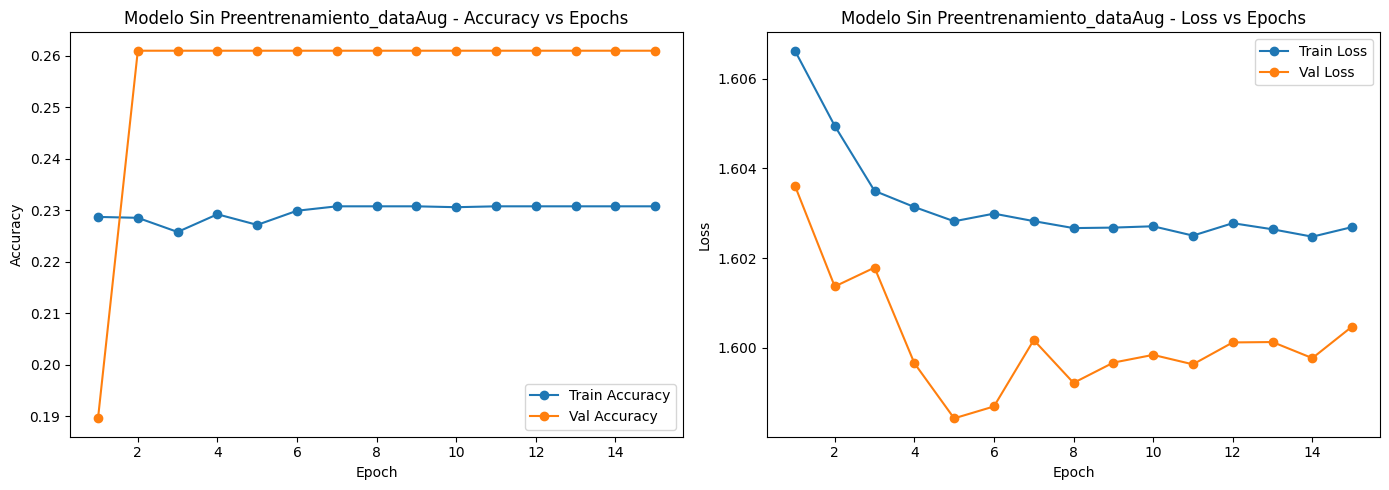

In [21]:
modelo_crudo = create_vgg19_from_scratch(num_classes, device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(modelo_crudo.parameters(), lr=learning_rate)

model_type = "Modelo Sin Preentrenamiento_dataAug"
model_name = f"{model_type}_v{version_modelo_crudo}"


# Entrenamiento
train_losses, val_losses, train_accuracies, val_accuracies = train_model(
        modelo_crudo, train_loader, val_loader, criterion, optimizer, num_epochs_crudo, device
    )
# Testing
test_accuracy = test_model(modelo_crudo, test_loader, device)
print(f"\nFinal Test Accuracy ({model_type}): {test_accuracy:.2f}%")

# Plot
plot_training_history(train_losses, val_losses, train_accuracies, val_accuracies,
                      title_prefix=f"{model_type} - ")

model_info = {
    "model_type": model_type,

    "num_classes": num_classes,
    "num_epochs": num_epochs_crudo,
    "learning_rate": learning_rate,
    "batch_size": batch_size,
    "optimizer": "Adam",
    "criterion": "CrossEntropyLoss"
}



Se evidencia que el modelo sin preentrenamiento tiene un fuerte subreajuste 

In [22]:
save_dir = "/content/drive/MyDrive/ModelosRNN/Proyecto 3"
saved_files = save_model_and_metrics(
    model=modelo_crudo,
    model_name=model_name,
    test_accuracy=test_accuracy,
    training_history=(train_losses, val_losses, train_accuracies, val_accuracies),
    model_info=model_info,
    save_dir=save_dir
)


✅ Model and metrics saved successfully!
📁 Save directory: /content/drive/MyDrive/ModelosRNN/Proyecto 3
🏷️  Model name: Modelo Sin Preentrenamiento_dataAug_v2
📊 Files saved:
   - Model weights: Modelo Sin Preentrenamiento_dataAug_v2_20250701_173046_model.pth
   - Full model: Modelo Sin Preentrenamiento_dataAug_v2_20250701_173046_full_model.pth
   - Metrics: Modelo Sin Preentrenamiento_dataAug_v2_20250701_173046_metrics.json
   - Plots: Modelo Sin Preentrenamiento_dataAug_v2_20250701_173046_plots.png


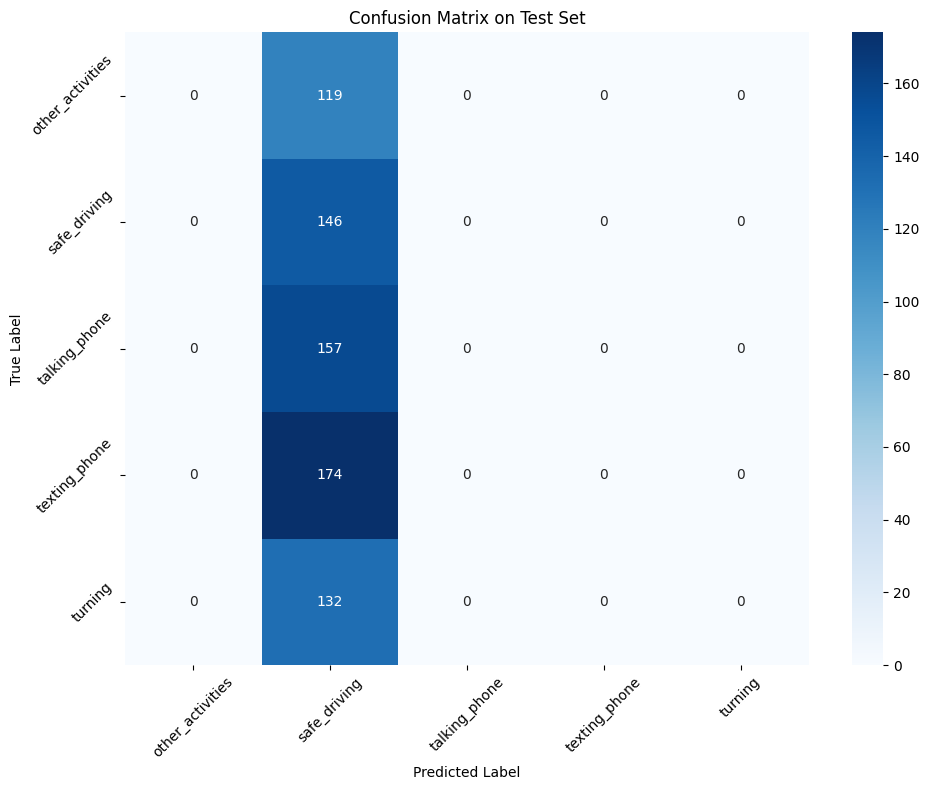

In [23]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
all_preds_crudo = []
all_labels_crudo = []

modelo_crudo.eval()
with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        outputs = modelo_crudo(images)
        _, preds = torch.max(outputs, 1)
        all_preds_crudo.extend(preds.cpu().numpy())
        all_labels_crudo.extend(labels.numpy())

# Compute confusion matrix
cm = confusion_matrix(all_labels_crudo, all_preds_crudo)
class_names = train_dataset.classes

# Plot confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix on Test Set')
plt.xticks(rotation=45)
plt.yticks(rotation=45)
plt.tight_layout()
plt.savefig(f"/content/drive/MyDrive/ModelosRNN/Proyecto 3/{model_name}confusion_matrix.png", dpi=300)
plt.show()

In [24]:
print(classification_report(all_labels_crudo, all_preds_crudo, target_names = ["other_activities","safe_driving","talking_phone","texting_phone","turning"]))

                  precision    recall  f1-score   support

other_activities       0.00      0.00      0.00       119
    safe_driving       0.20      1.00      0.33       146
   talking_phone       0.00      0.00      0.00       157
   texting_phone       0.00      0.00      0.00       174
         turning       0.00      0.00      0.00       132

        accuracy                           0.20       728
       macro avg       0.04      0.20      0.07       728
    weighted avg       0.04      0.20      0.07       728



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


# Entrenamiento Modelo Preentrenado

In [25]:
version_modelo_preentrenado = 2
num_epochs_pretrained = 15

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG19_Weights.IMAGENET1K_V1`. You can also use `weights=VGG19_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Loading VGG19 pretrained model...


Downloading: "https://download.pytorch.org/models/vgg19-dcbb9e9d.pth" to /root/.cache/torch/hub/checkpoints/vgg19-dcbb9e9d.pth
100%|██████████| 548M/548M [00:10<00:00, 56.4MB/s]


Starting training...
Early stopping: patience=10, min_delta=0.001

Epoch 1/15
Train Loss: 1.4177, Train Acc: 34.59%
Val Loss: 1.0398, Val Acc: 56.73%
✓ New best validation loss: 1.0398

Epoch 2/15
Train Loss: 1.0096, Train Acc: 57.58%
Val Loss: 0.7467, Val Acc: 71.29%
✓ New best validation loss: 0.7467

Epoch 3/15
Train Loss: 0.5547, Train Acc: 78.78%
Val Loss: 0.3758, Val Acc: 85.99%
✓ New best validation loss: 0.3758

Epoch 4/15
Train Loss: 0.3379, Train Acc: 87.37%
Val Loss: 0.2715, Val Acc: 90.11%
✓ New best validation loss: 0.2715

Epoch 5/15
Train Loss: 0.2727, Train Acc: 90.07%
Val Loss: 0.2256, Val Acc: 91.90%
✓ New best validation loss: 0.2256

Epoch 6/15
Train Loss: 0.2366, Train Acc: 91.10%
Val Loss: 0.2412, Val Acc: 91.48%
No improvement for 1 epochs

Epoch 7/15
Train Loss: 0.2187, Train Acc: 91.55%
Val Loss: 0.2228, Val Acc: 92.31%
✓ New best validation loss: 0.2228

Epoch 8/15
Train Loss: 0.2170, Train Acc: 91.98%
Val Loss: 0.1837, Val Acc: 91.48%
✓ New best validation lo

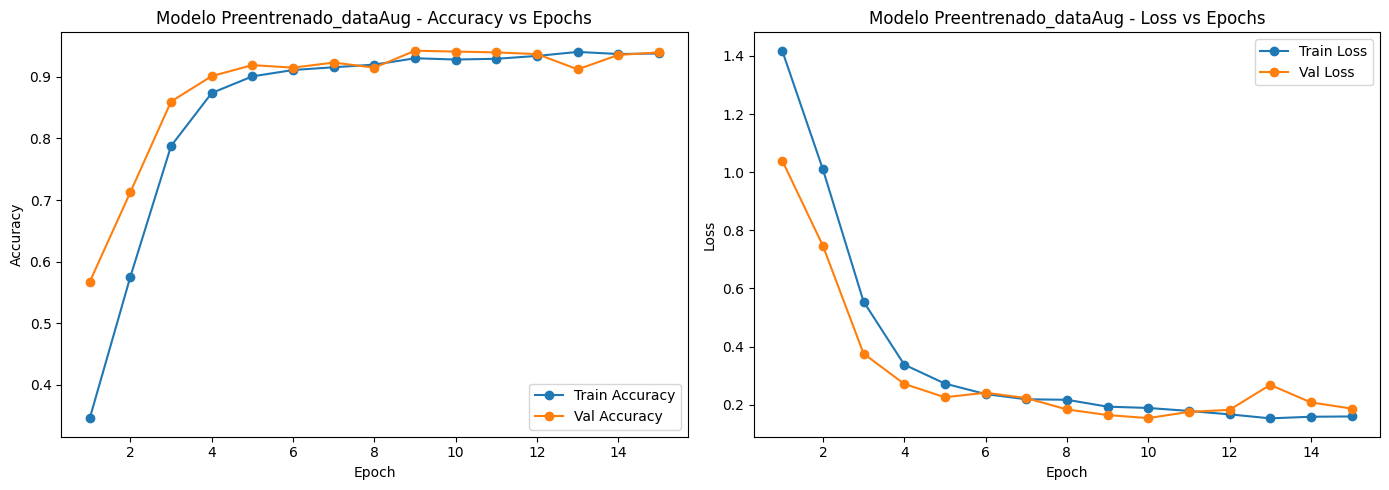

In [26]:
modelo_preentrenado = create_vgg19_pretrained(num_classes, device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(modelo_preentrenado.parameters(), lr=learning_rate)

model_type = "Modelo Preentrenado_dataAug"
model_name = f"{model_type}_v{version_modelo_preentrenado}"


# Entrenamiento
train_losses, val_losses, train_accuracies, val_accuracies = train_model(
        modelo_preentrenado, train_loader, val_loader, criterion, optimizer, num_epochs_pretrained, device
    )
# Testing
test_accuracy = test_model(modelo_preentrenado, test_loader, device)
print(f"\nFinal Test Accuracy ({model_type}): {test_accuracy:.2f}%")

# Plot
plot_training_history(train_losses, val_losses, train_accuracies, val_accuracies,
                      title_prefix=f"{model_type} - ")

model_info = {
    "model_type": model_type,

    "num_classes": num_classes,
    "num_epochs": num_epochs_pretrained,
    "learning_rate": learning_rate,
    "batch_size": batch_size,
    "optimizer": "Adam",
    "criterion": "CrossEntropyLoss"
}



In [27]:
save_dir = "/content/drive/MyDrive/ModelosRNN/Proyecto 3"
saved_files = save_model_and_metrics(
    model=modelo_preentrenado,
    model_name=model_name,
    test_accuracy=test_accuracy,
    training_history=(train_losses, val_losses, train_accuracies, val_accuracies),
    model_info=model_info,
    save_dir=save_dir
)


✅ Model and metrics saved successfully!
📁 Save directory: /content/drive/MyDrive/ModelosRNN/Proyecto 3
🏷️  Model name: Modelo Preentrenado_dataAug_v2
📊 Files saved:
   - Model weights: Modelo Preentrenado_dataAug_v2_20250701_180011_model.pth
   - Full model: Modelo Preentrenado_dataAug_v2_20250701_180011_full_model.pth
   - Metrics: Modelo Preentrenado_dataAug_v2_20250701_180011_metrics.json
   - Plots: Modelo Preentrenado_dataAug_v2_20250701_180011_plots.png


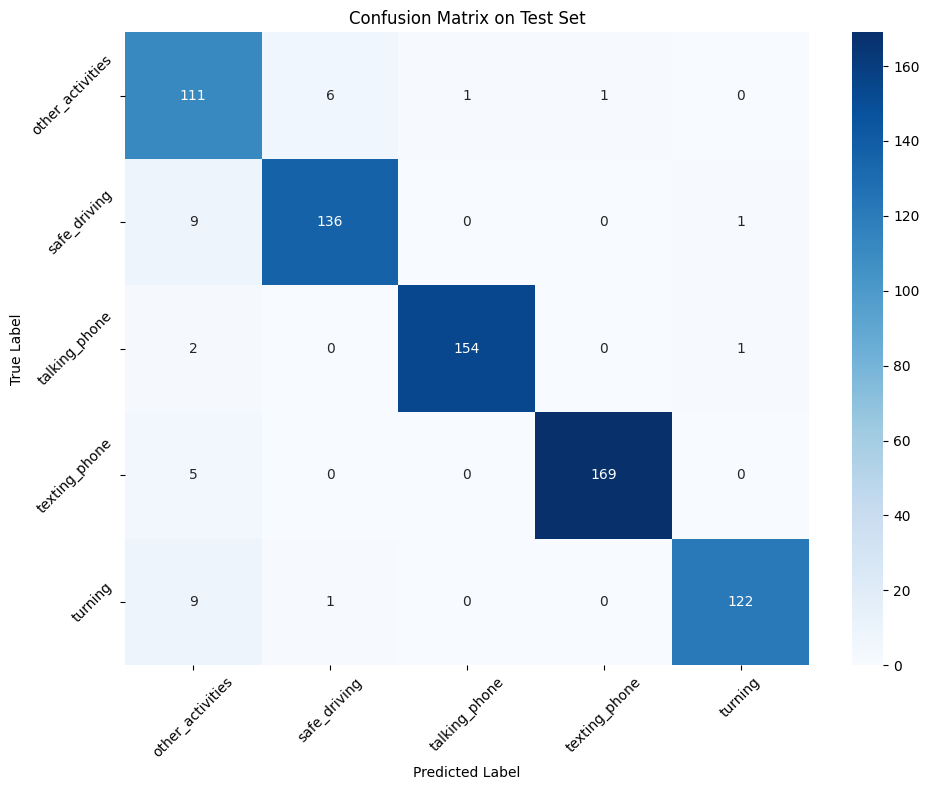

In [28]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
all_preds_preentrenado = []
all_labels_preentrenado = []

modelo_preentrenado.eval()
with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        outputs = modelo_preentrenado(images)
        _, preds = torch.max(outputs, 1)
        all_preds_preentrenado.extend(preds.cpu().numpy())
        all_labels_preentrenado.extend(labels.numpy())

# Compute confusion matrix
cm = confusion_matrix(all_labels_preentrenado, all_preds_preentrenado)
class_names = train_dataset.classes

# Plot confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix on Test Set')
plt.xticks(rotation=45)
plt.yticks(rotation=45)
plt.tight_layout()
plt.savefig(f"/content/drive/MyDrive/ModelosRNN/Proyecto 3/{model_name}confusion_matrix.png", dpi=300)
plt.show()

In [29]:
print(classification_report(all_labels_preentrenado, all_preds_preentrenado, target_names = ["other_activities","safe_driving","talking_phone","texting_phone","turning"]))

                  precision    recall  f1-score   support

other_activities       0.82      0.93      0.87       119
    safe_driving       0.95      0.93      0.94       146
   talking_phone       0.99      0.98      0.99       157
   texting_phone       0.99      0.97      0.98       174
         turning       0.98      0.92      0.95       132

        accuracy                           0.95       728
       macro avg       0.95      0.95      0.95       728
    weighted avg       0.95      0.95      0.95       728



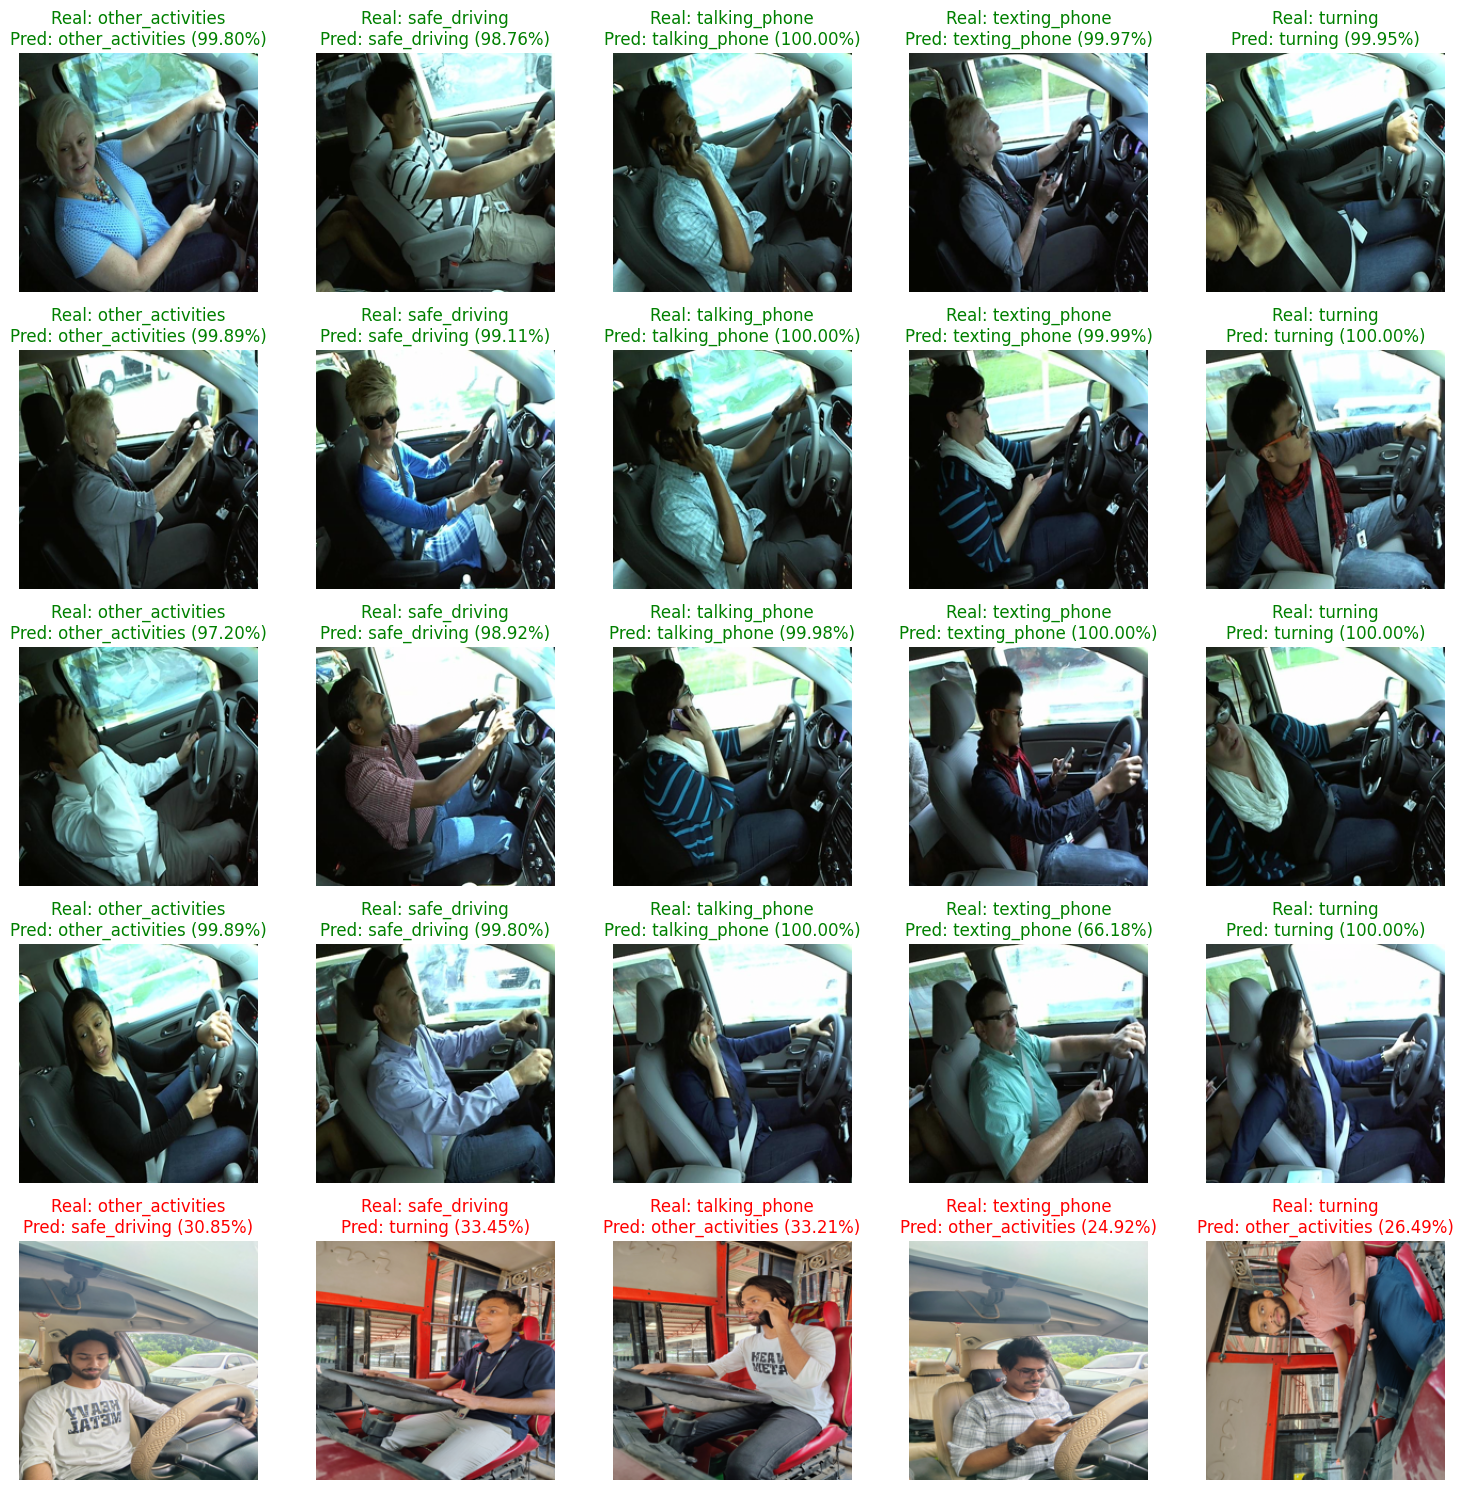

In [36]:
# Lista de nombres de clases en el mismo orden que el entrenamiento
class_labels = ["other_activities","safe_driving","talking_phone","texting_phone","turning"]


# Función auxiliar para deshacer la normalización y mostrar imágenes
def denormalize(tensor):
    mean = torch.tensor([0.485, 0.456, 0.406]).view(3, 1, 1)
    std = torch.tensor([0.229, 0.224, 0.225]).view(3, 1, 1)
    return (tensor * std + mean).clamp(0, 1)

# Mostrar predicciones de un modelo PyTorch
def show_predictions(model, dataset, device='cpu', num_images_per_class=5):
    model.eval()
    num_classes = len(class_labels)

    # Organize dataset indices by true class
    class_indices = {i: [] for i in range(num_classes)}
    for idx, (_, label) in enumerate(dataset):
        class_indices[label].append(idx)

    fig, axes = plt.subplots(num_images_per_class, num_classes, figsize=(num_classes * 3, num_images_per_class * 3))

    for class_idx in range(num_classes):
        all_samples = []
        one_wrong_candidate = None

        for idx in class_indices[class_idx]:
            image_tensor, label = dataset[idx]
            input_tensor = image_tensor.unsqueeze(0).to(device)

            with torch.no_grad():
                output = model(input_tensor)
                probs = F.softmax(output, dim=1).cpu().squeeze().numpy()
                pred_idx = np.argmax(probs)

            # Store each sample's info
            sample = (idx, probs, pred_idx)
            all_samples.append(sample)

            # Save first wrong prediction if available
            if pred_idx != class_idx and one_wrong_candidate is None:
                one_wrong_candidate = sample

        # Shuffle and choose first N-1
        np.random.shuffle(all_samples)
        selected = all_samples[:num_images_per_class - 1]

        # Check if any wrongs are already included
        has_wrong = any(pred_idx != class_idx for _, _, pred_idx in selected)

        # Add a guaranteed wrong at the end if needed
        if not has_wrong and one_wrong_candidate:
            selected.append(one_wrong_candidate)
        else:
            # Fill up to N samples
            for sample in all_samples:
                if sample not in selected:
                    selected.append(sample)
                if len(selected) == num_images_per_class:
                    break

        # Plot
        for row, (img_idx, probs, pred_idx) in enumerate(selected):
            image_tensor, true_label = dataset[img_idx]
            img_np = denormalize(image_tensor.cpu()).permute(1, 2, 0).numpy()

            ax = axes[row, class_idx]
            ax.imshow(img_np)
            ax.axis('off')

            pred_label = class_labels[pred_idx]
            true_label_str = class_labels[true_label]
            pred_prob = probs[pred_idx]
            color = "green" if pred_idx == true_label else "red"

            ax.set_title(f"Real: {true_label_str}\nPred: {pred_label} ({pred_prob:.2%})", color=color)

    plt.tight_layout()
    plt.show()


# Llamar a la función con 5 imágenes por clase
show_predictions(modelo_preentrenado, test_dataset, device=device, num_images_per_class=5)
